<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

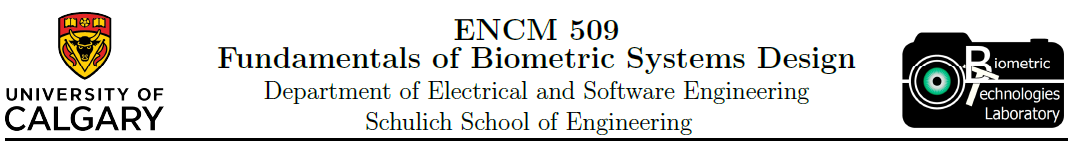

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
</center>

#### UCID 1: 30085789
#### Name 1: Abhay Khosla

#### UCID 2: 30096001
#### Name 2: Parbir Lehal

#### Group Number: 07

## Introduction
In biometric authentication, face recognition technology has become a popular method for identifying and verifying individuals. This usually involves checking for the detection of facial features and with the help of image processing techniques to enhance the image and extract distinct features. These features are usually collected in a feature vector which is like a template that is used to classify the face. In this lab our aim is to understand the process of face recongition using Principal Component Analysis (PCA) which is extraction of the features and K-Nearest Neighbours (KNN) algorithm is a simple classifier that does similarity scoring. We will be using different Python libraries to perform the tasks and evaluate the results in this lab report.   

**Exercise 1** (3 marks): For this exercise, you are going to build a gallery and perform the classification (matching) for the three cases (face known to the gallery, face unknown to the gallery and not-a-face). You need to choose two or three different subjects (for example, subjects 2, 3 and 4) from the dataset, or create your own dataset. Use the first 9 images of each subject to build the gallery dataset. For example, if you choose 3 subjects, then you have a gallery of 3 x 9 = 27 faces, and for algorithm each image is a sample, or input (no separate model is built per subject).

- Now, choose the probe images as follows:
    1. The 10th image of each of the three subjects in the dataset.
    2. 2-3 faces of the subjects not known to the dataset (could be yours, if you wish).
    3. 1-2 not-a-face image.

    For each of the comparisons, save the Euclidean distances calculated and annotate the minimum and maximum value in each case.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

### Case 1: Face known to the gallery for Subject 4

Size of each image: (112, 92) 10304
Normalized Images for Subject 4


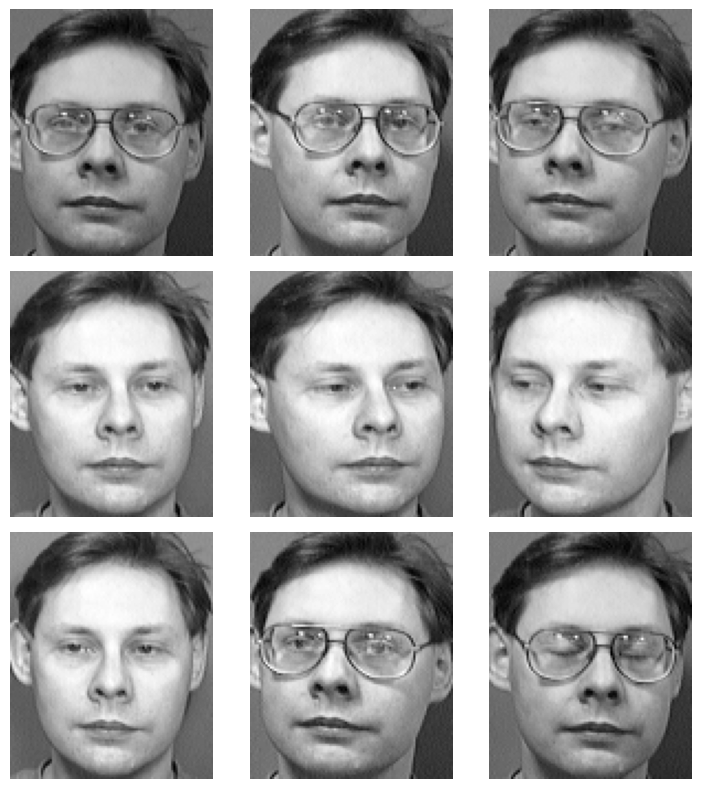

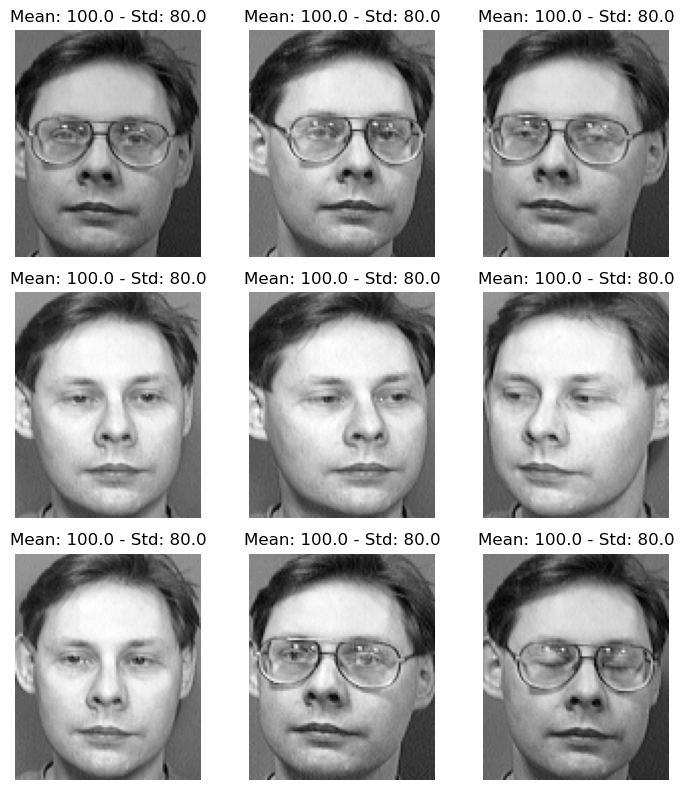

In [2]:
# The dataset we will be using is Subject 4 from the ATT
path = './ATT dataset/s4/'
M = 9 # Load only 9 as the 10th one will be for comparing later on 
# For performing the image normalization
# It can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

plt.figure(figsize=(8,8))
for i in range(1,M+1):
    img = imread(path + '{}.pgm'.format(i), as_gray=True)
    
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

# The Normalized images for Subject 4
print("Normalized Images for Subject 4")
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

Text(0.5, 1.0, 'Mean Image')

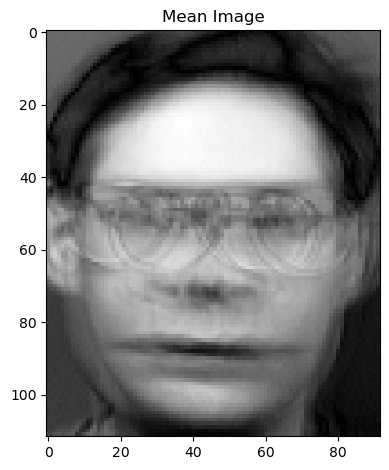

In [3]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image')

/var/folders/37/q_fxhxq90_d06y854bb7r8lw0000gn/T/ipykernel_11968/4160835833.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


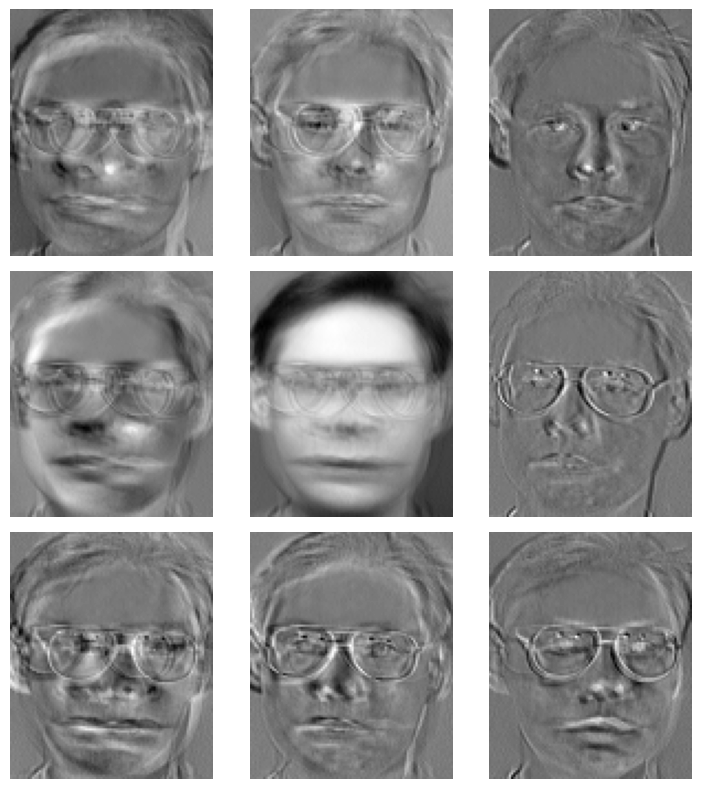

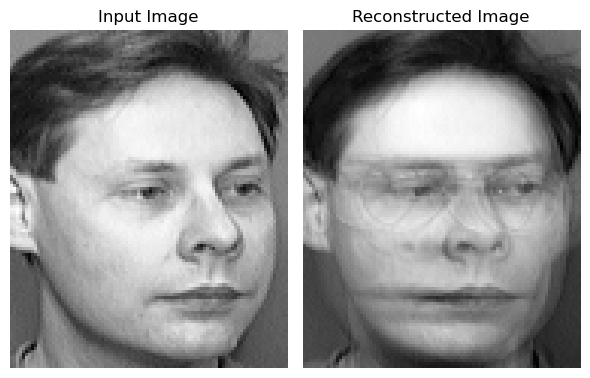

In [4]:
# Creating the covariance matrix L 
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

# Sort and eliminate zero eigenvalue
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

# Normalization of eigenvectors
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

# Showing eigenfaces
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Find the weight of each face in the training set
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

# using the last image of subject #4
path = './ATT dataset/s4/'
InputImage = imread(path + '10.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage


Text(0.5, 1.0, 'Euclidean Distances: Same subject\nMin 12707.79, Max 14312.99')

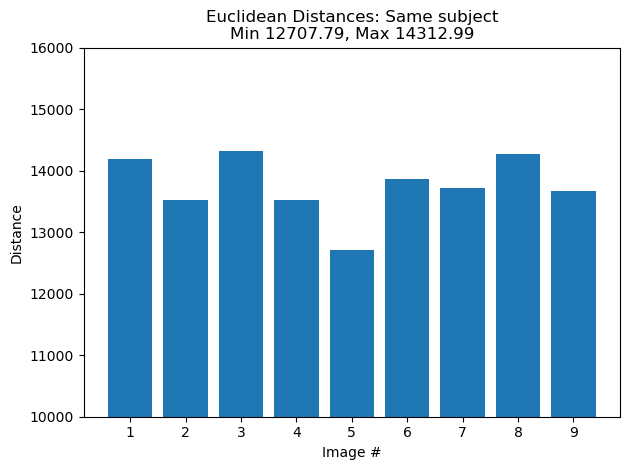

In [5]:
# Finding the Euclidean Distance of the same subject
eSameSubject4 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject4[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject4) 
MinimumValue = np.min(eSameSubject4) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eSameSubject4)), eSameSubject4.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 2 : Face unknown to the gallery for Subject 4 against Subject 12

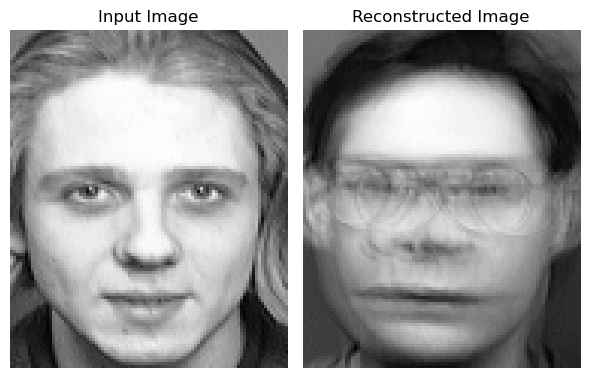

In [86]:
# using the first face ('1.pgm') from subject 12
path = './ATT dataset/s12/'
InputImage = imread(path + '1.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Other subject\nMin 13344.18, Max 14173.46')

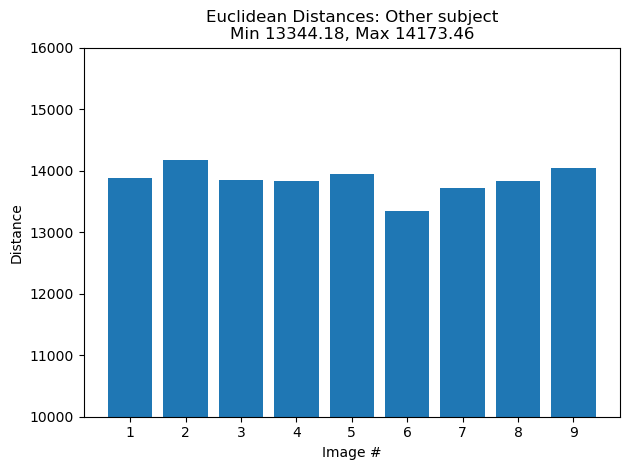

In [87]:
# Finding the Euclidean distance of a different subject a face not known to the gallery 
eDiffSubject4Probe1 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject4Probe1[i] = mag
    
# max/min Euclidean distance
MaximumValue = np.max(eDiffSubject4Probe1) 
MinimumValue = np.min(eDiffSubject4Probe1) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject4Probe1)), eDiffSubject4Probe1.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 2 : Face unknown to the gallery for Subject 4 against Subject 24

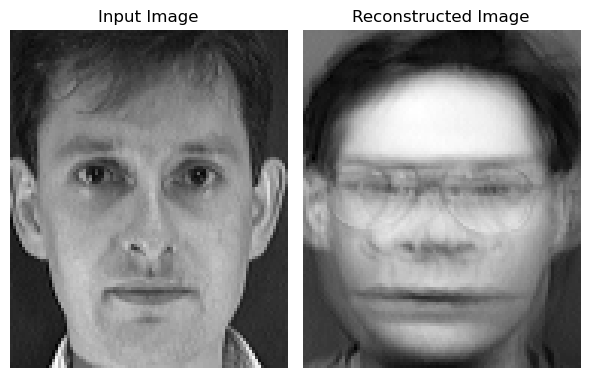

In [88]:
# using the first face ('1.pgm') from subject 24
path = './ATT dataset/s24/'
InputImage = imread(path + '1.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Other subject\nMin 13911.77, Max 14537.09')

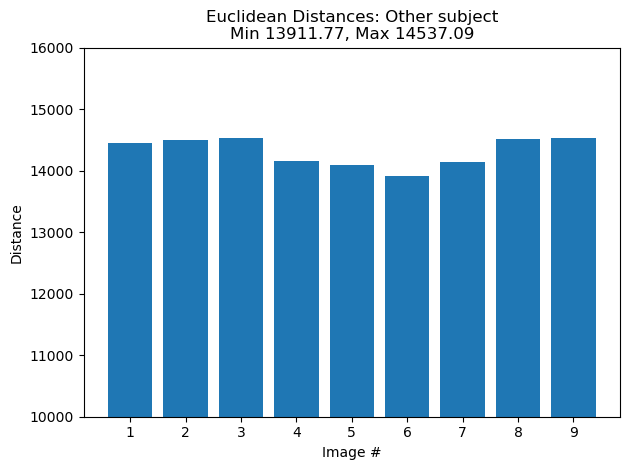

In [89]:
# Finding the Euclidean distance of a different subject a face not known to the gallery 
eDiffSubject4Probe2 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject4Probe2[i] = mag
    
# max/min Euclidean distance
MaximumValue = np.max(eDiffSubject4Probe2) 
MinimumValue = np.min(eDiffSubject4Probe2) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject4Probe2)), eDiffSubject4Probe2.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 3: Not-a-face image for Subject 4

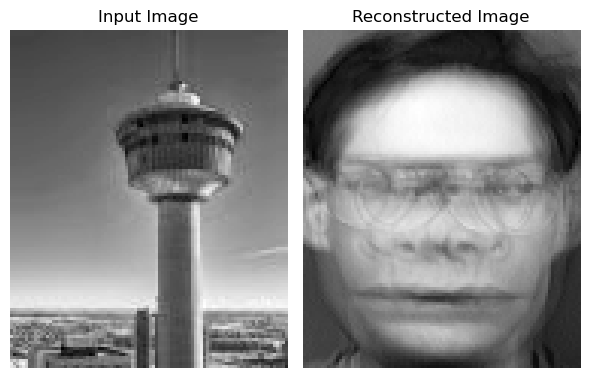

In [90]:
# Using the Calgary Tower as a non human face image
path = './'
InputImage = imread(path + 'CalgaryTower.jpg', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Not human face\nMin 16400.90, Max 16957.04')

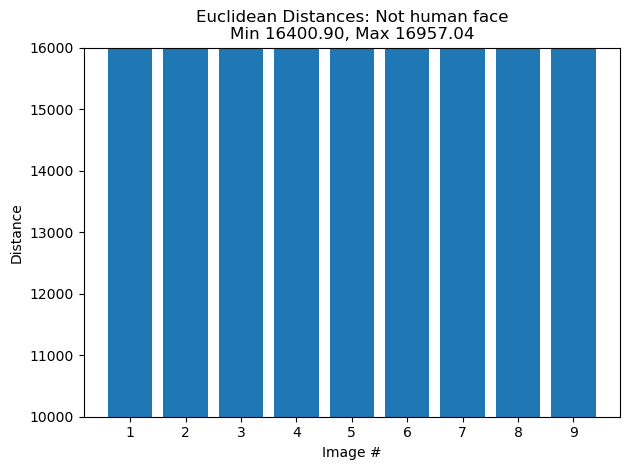

In [91]:
# Finding the Euclidean distance of a not human face with the subject
eTowerSubject4 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTowerSubject4[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eTowerSubject4) 
MinimumValue = np.min(eTowerSubject4) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eTowerSubject4)), eTowerSubject4.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 1: Face known to the gallery for Subject 5

Size of each image: (112, 92) 10304
Normalized Images for Subject 5


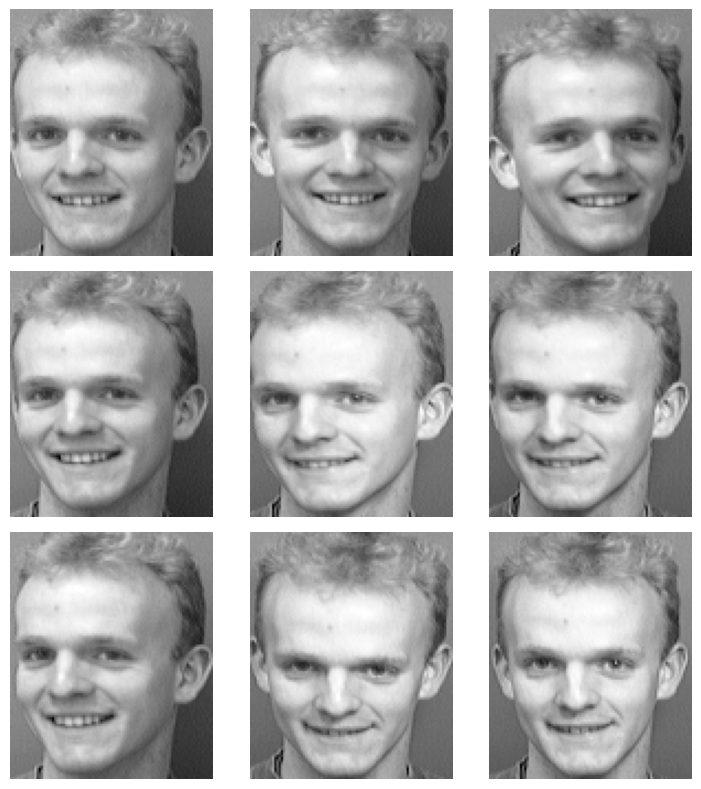

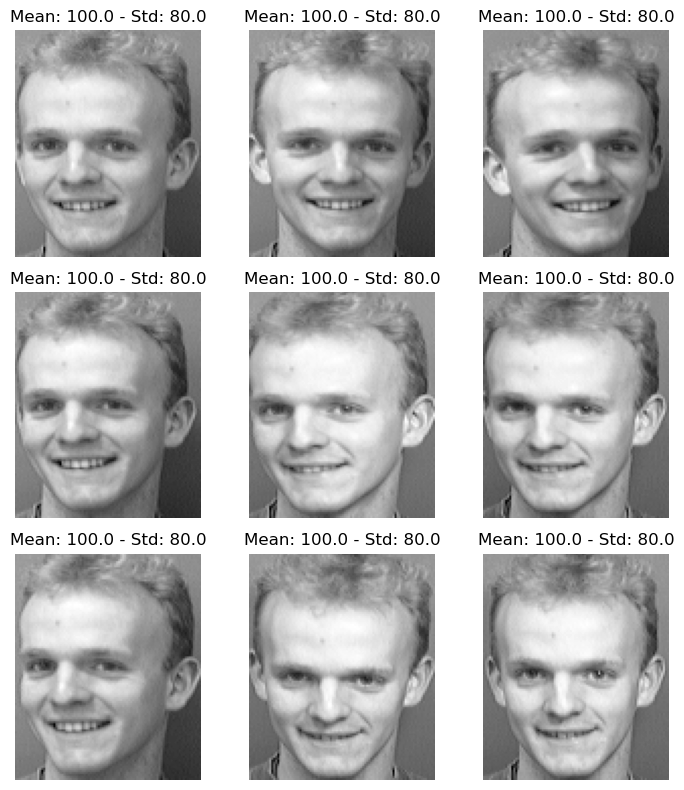

In [92]:
# The dataset we will be using is Subject 5 from the ATT
path = './ATT dataset/s5/'
M = 9 # Load only 9 as the 10th one will be for comparing later on 
# For performing the image normalization
# It can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

plt.figure(figsize=(8,8))
for i in range(1,M+1):
    img = imread(path + '{}.pgm'.format(i), as_gray=True)
    
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

# The Normalized images for Subject 5
print("Normalized Images for Subject 5")
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

Text(0.5, 1.0, 'Mean Image')

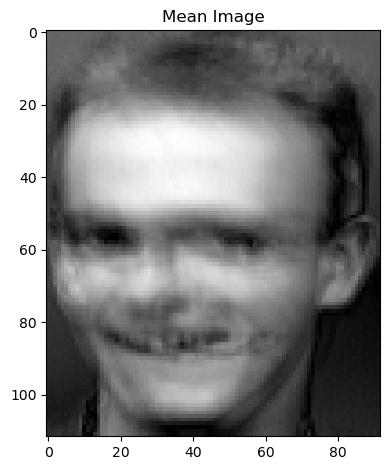

In [93]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image')

C:\Users\abhay\AppData\Local\Temp\ipykernel_21696\2108444852.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


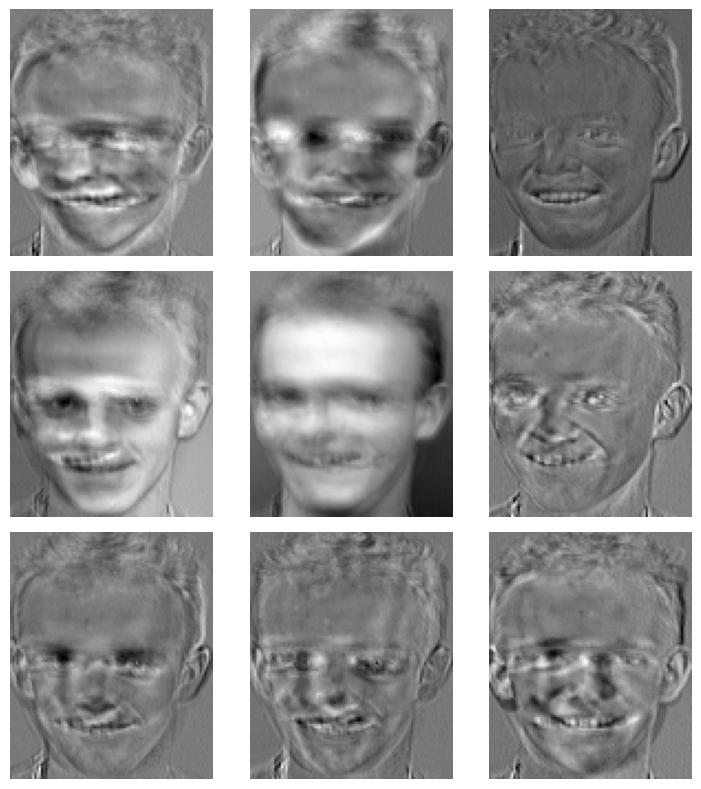

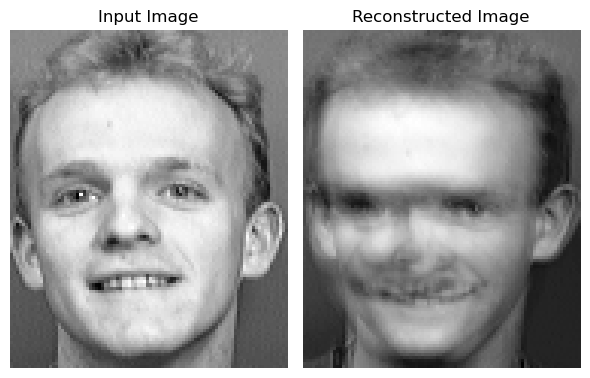

In [94]:
# Creating the covariance matrix L 
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

# Sort and eliminate zero eigenvalue
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

# Normalization of eigenvectors
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

# Showing eigenfaces
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Find the weight of each face in the training set
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

# using the last image of subject #5
path = './ATT dataset/s5/'
InputImage = imread(path + '10.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage


Text(0.5, 1.0, 'Euclidean Distances: Same subject\nMin 13081.42, Max 13936.55')

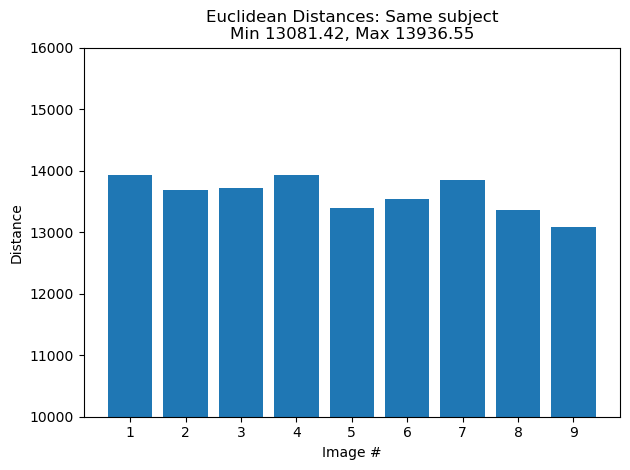

In [95]:
# Finding the Euclidean Distance of the same subject
eSameSubject5 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject5[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject5) 
MinimumValue = np.min(eSameSubject5) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eSameSubject5)), eSameSubject5.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 2 : Face unknown to the gallery for Subject 5 against Subject 12

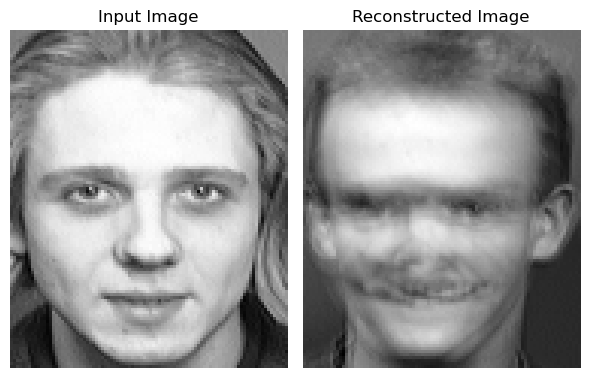

In [96]:
# using the first face ('1.pgm') from subject 12
path = './ATT dataset/s12/'
InputImage = imread(path + '1.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Other subject\nMin 13270.14, Max 14449.43')

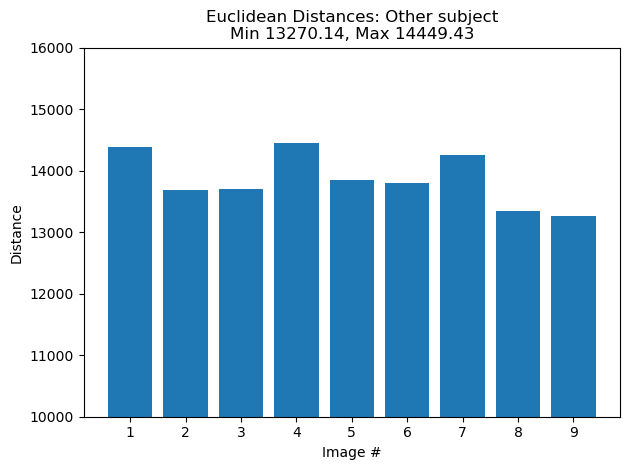

In [97]:
# Finding the Euclidean distance of a different subject a face not known to the gallery 
eDiffSubject5Probe1 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject5Probe1[i] = mag
    
# max/min Euclidean distance
MaximumValue = np.max(eDiffSubject5Probe1) 
MinimumValue = np.min(eDiffSubject5Probe1) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject5Probe1)), eDiffSubject5Probe1.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 2 : Face unknown to the gallery for Subject 5 against Subject 24

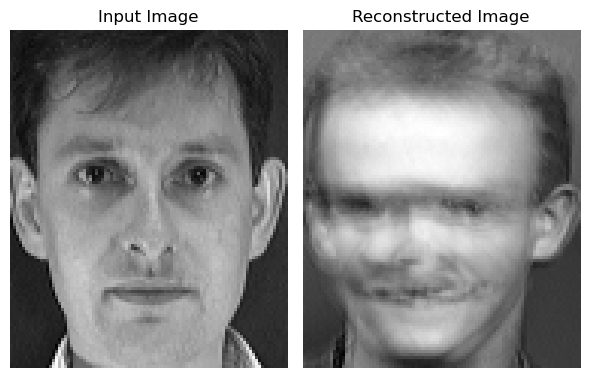

In [98]:
# using the first face ('1.pgm') from subject 24
path = './ATT dataset/s24/'
InputImage = imread(path + '1.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Other subject\nMin 14496.17, Max 15882.69')

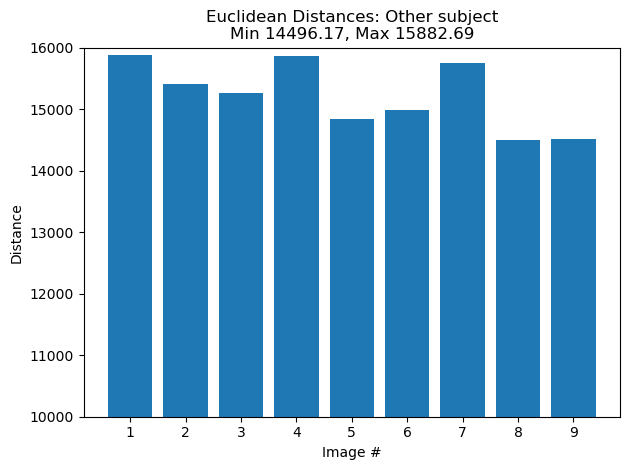

In [99]:
# Finding the Euclidean distance of a different subject a face not known to the gallery 
eDiffSubject5Probe2 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject5Probe2[i] = mag
    
# max/min Euclidean distance
MaximumValue = np.max(eDiffSubject5Probe2) 
MinimumValue = np.min(eDiffSubject5Probe2) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject5Probe2)), eDiffSubject5Probe2.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 3: Not-a-face image for Subject 5

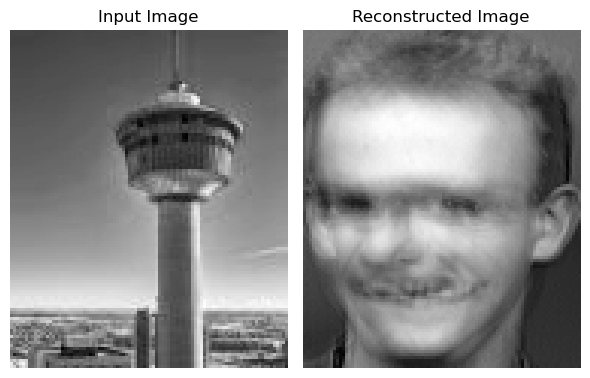

In [100]:
# Using the Calgary Tower as a non human face image
path = './'
InputImage = imread(path + 'CalgaryTower.jpg', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Not human face\nMin 17398.89, Max 18039.31')

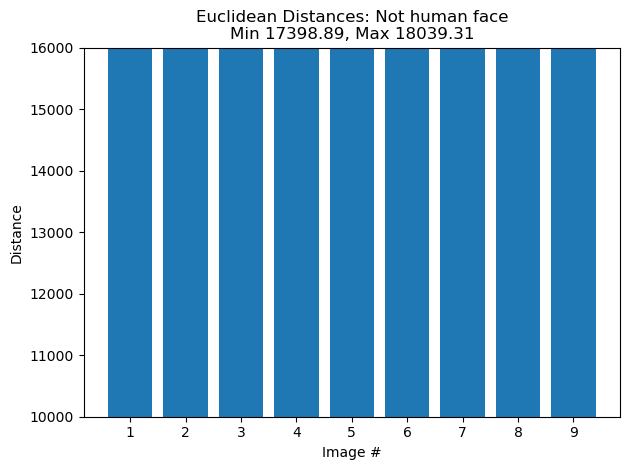

In [101]:
# Finding the Euclidean distance of a not human face with the subject
eTowerSubject5 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTowerSubject5[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eTowerSubject5) 
MinimumValue = np.min(eTowerSubject5) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eTowerSubject5)), eTowerSubject5.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 1: Face known to the gallery for Subject 6

Size of each image: (112, 92) 10304
Normalized Images for Subject 6


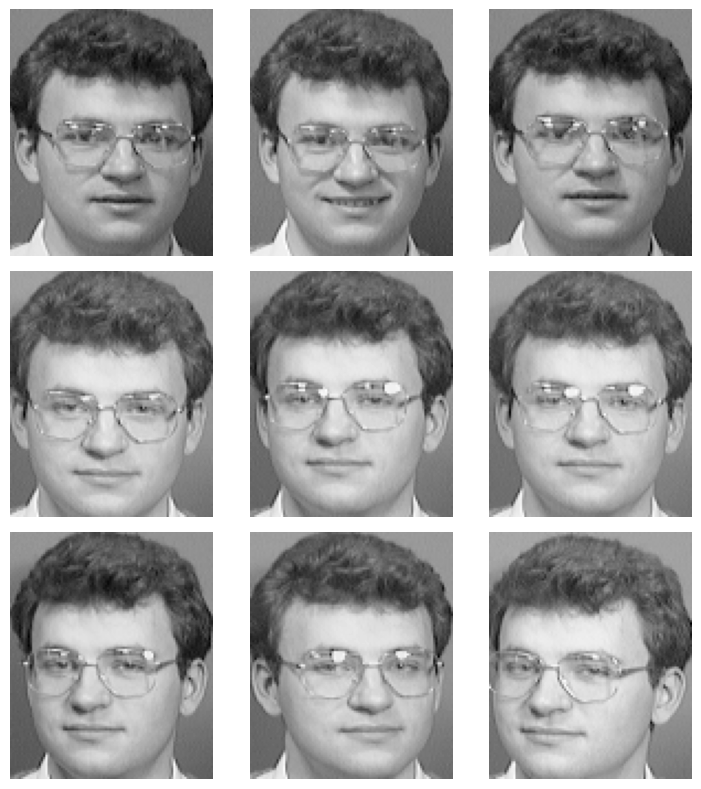

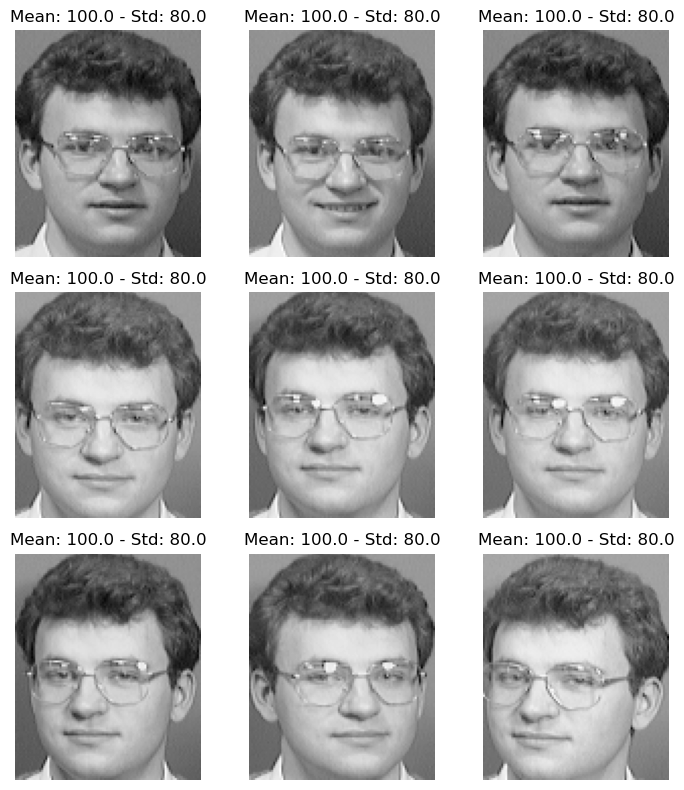

In [102]:
# The dataset we will be using is Subject 6 from the ATT
path = './ATT dataset/s6/'
M = 9 # Load only 9 as the 10th one will be for comparing later on 
# For performing the image normalization
# It can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(path + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

plt.figure(figsize=(8,8))
for i in range(1,M+1):
    img = imread(path + '{}.pgm'.format(i), as_gray=True)
    
    plt.subplot(3,3,i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # reshape(img',irow*icol,1); 
    # creates a (N1*N2)x1 vector
    temp = np.reshape(img, (irow*icol,1))
    S[:,i-1] = temp[:,0] 
# after finishing the sequence, S is a N1*N2xM matrix 

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

# The Normalized images for Subject 6
print("Normalized Images for Subject 6")
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

Text(0.5, 1.0, 'Mean Image')

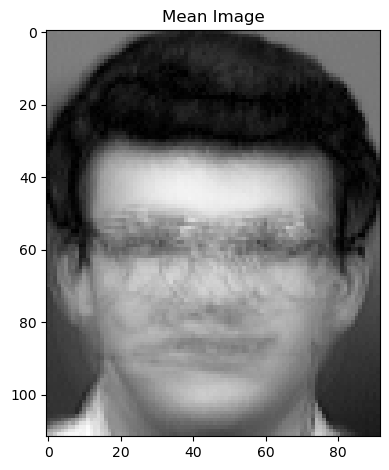

In [103]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image')

C:\Users\abhay\AppData\Local\Temp\ipykernel_21696\1862983918.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


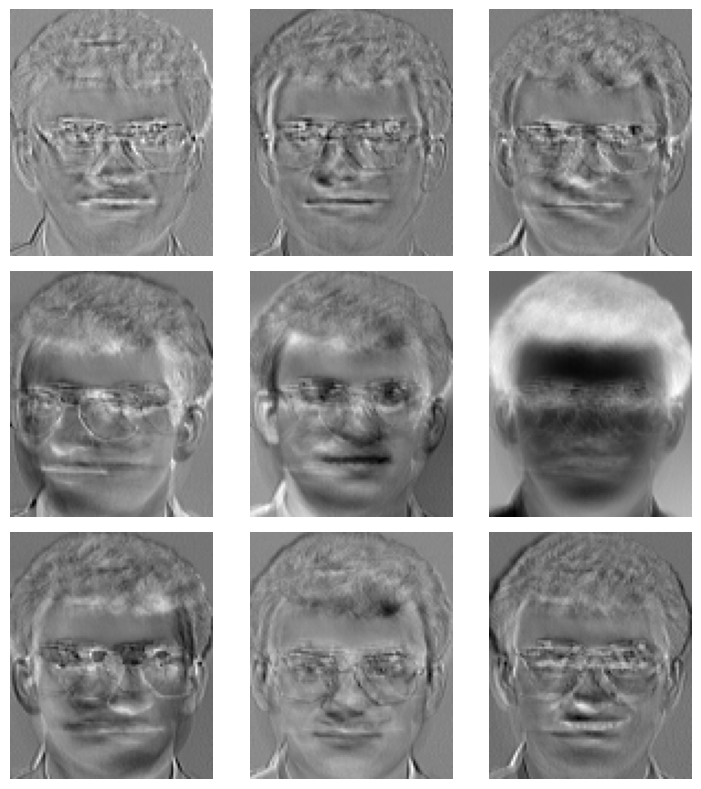

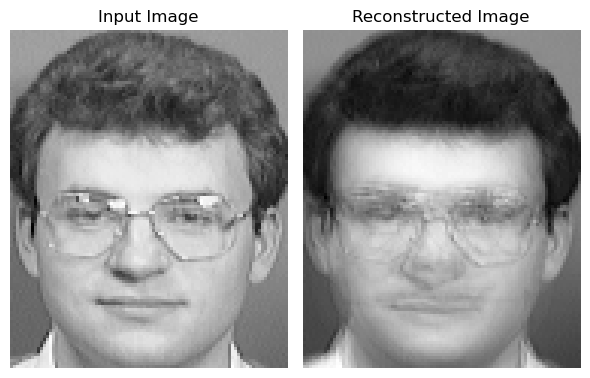

In [104]:
# Creating the covariance matrix L 
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

# Sort and eliminate zero eigenvalue
v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

# Normalization of eigenvectors
for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

# Showing eigenfaces
plt.figure(figsize=(8,8))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Find the weight of each face in the training set
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

# using the last image of subject #6
path = './ATT dataset/s6/'
InputImage = imread(path + '10.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage


Text(0.5, 1.0, 'Euclidean Distances: Same subject\nMin 12402.29, Max 13506.46')

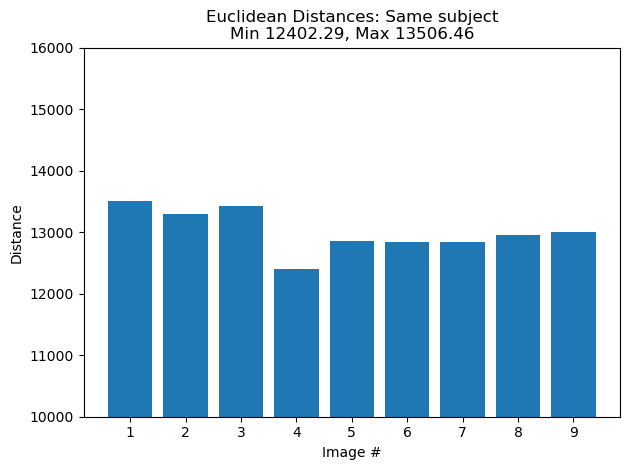

In [105]:
# Finding the Euclidean Distance of the same subject
eSameSubject6 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eSameSubject6[i] = mag

# max/min Euclidean distance
MaximumValue = np.max(eSameSubject6) 
MinimumValue = np.min(eSameSubject6) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eSameSubject6)), eSameSubject6.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Same subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 2 : Face unknown to the gallery for Subject 6 against Subject 12

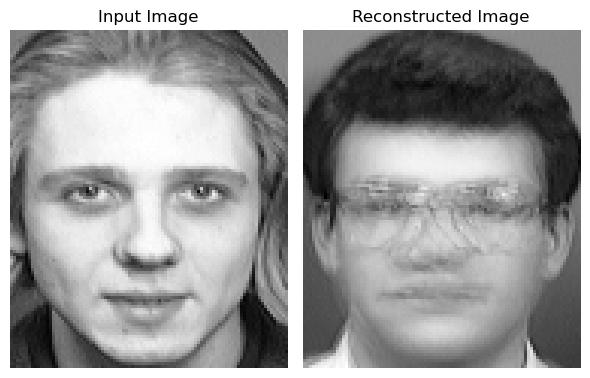

In [106]:
# using the first face ('1.pgm') from subject 12
path = './ATT dataset/s12/'
InputImage = imread(path + '1.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Other subject\nMin 15641.29, Max 16144.24')

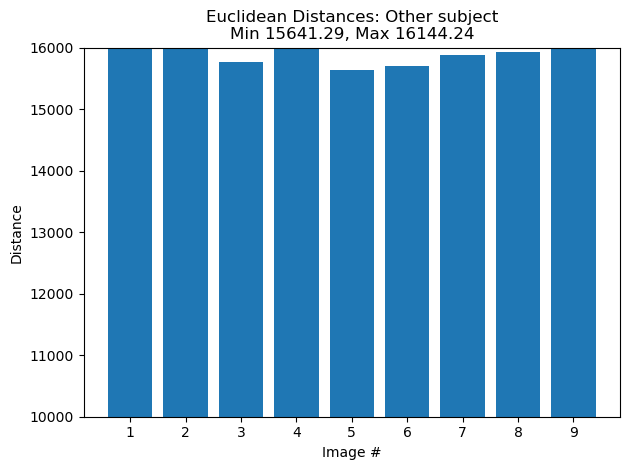

In [107]:
# Finding the Euclidean distance of a different subject a face not known to the gallery 
eDiffSubject6Probe1 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject6Probe1[i] = mag
    
# max/min Euclidean distance
MaximumValue = np.max(eDiffSubject6Probe1) 
MinimumValue = np.min(eDiffSubject6Probe1) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject6Probe1)), eDiffSubject6Probe1.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Case 2 : Face unknown to the gallery for Subject 6 against Subject 24

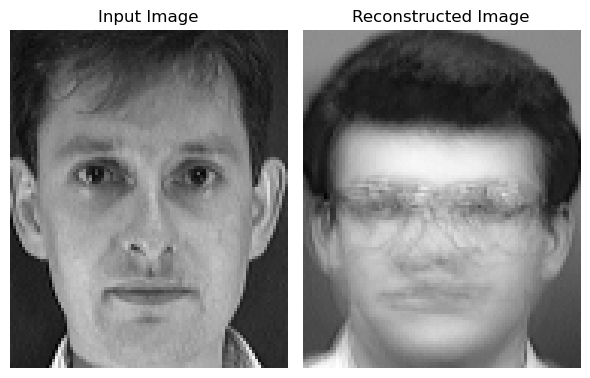

In [108]:
# using the first face ('1.pgm') from subject 24
path = './ATT dataset/s24/'
InputImage = imread(path + '1.pgm', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Other subject\nMin 14902.39, Max 15349.56')

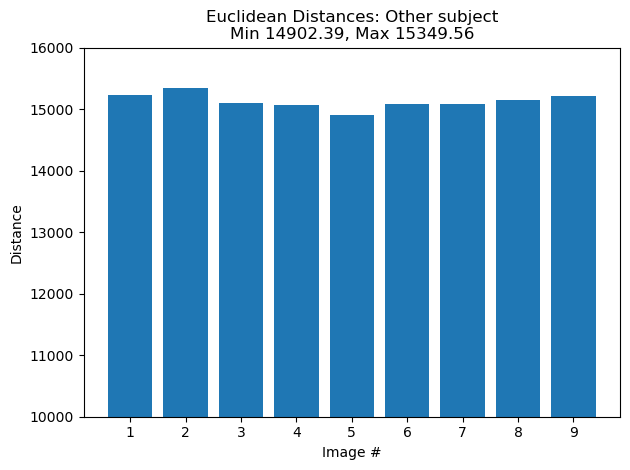

In [109]:
# Finding the Euclidean distance of a different subject a face not known to the gallery 
eDiffSubject6Probe2 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eDiffSubject6Probe2[i] = mag
    
# max/min Euclidean distance
MaximumValue = np.max(eDiffSubject6Probe2) 
MinimumValue = np.min(eDiffSubject6Probe2) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eDiffSubject6Probe2)), eDiffSubject6Probe2.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Other subject\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

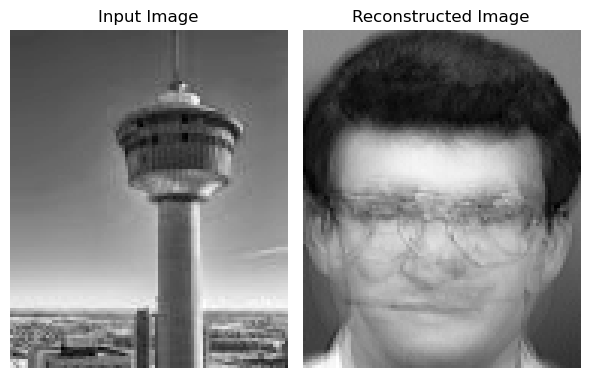

In [110]:
# Using the Calgary Tower as a non human face image
path = './'
InputImage = imread(path + 'CalgaryTower.jpg', as_gray=True)

plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage

Text(0.5, 1.0, 'Euclidean Distances: Not human face\nMin 15646.49, Max 16133.24')

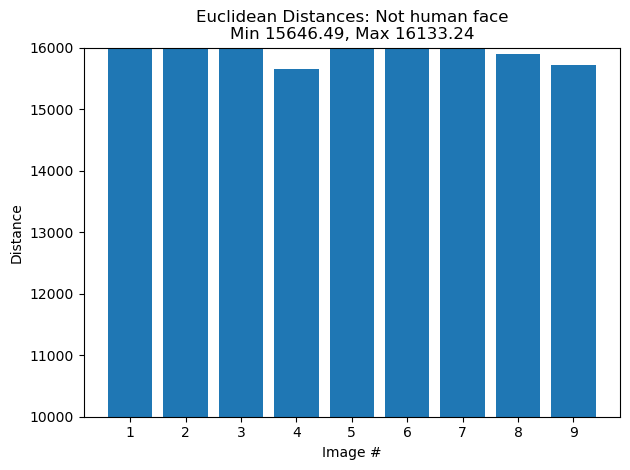

In [111]:
# Finding the Euclidean distance of a not human face with the subject
eTowerSubject6 = np.zeros((M,1))

for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTowerSubject6[i] = mag
    
# max/min Eucledian distance
MaximumValue = np.max(eTowerSubject6) 
MinimumValue = np.min(eTowerSubject6) 

labels = ('1', '2', '3', '4', '5', '6', '7', '8', '9')

plt.bar(np.arange(len(eTowerSubject6)), eTowerSubject6.flatten(), tick_label=labels)
plt.ylim([10000, 16000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
          'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

### Analysis and Learnings
We constructed a gallery using images of Subject 4,5 and 6 from the ATT dataset and performed classification to match faces known to the gallery, faces unknown to the gallery and not-a-face images. We learned that the quality of the images and the features extracted from the images play a crucial role in the classification. We also learned that a higher number of components may not necessarily lead to better recognition due to overfitting. It was insightful to observe the impact of the chosen components on the algorithm's accuracy and the importance of feature normalization to ensure the model's robustness against varying lighting conditions and facial expressions.

**Exercise 2** (3 marks):Determine the first and the second thresholds; hint: analyze the maximum of the Euclidean distances for the probe images known to the dataset. To find the second threshold, use unknown faces as the input faces and gather all the Euclidean distance. Hint: consider the maximum as the second threshold, but also analyze other values.

Extend the Lab’s Jupyter notebook, so that it can calculate the thresholds as investigated above in Exercise 2, and provide the decision output: ‘Face is known to the dataset, subject 2’, ‘Face is unknown to the dataset’, or ‘Not-a-face’. Draw conclusions and make suggestions on the procedure improvement.

### Choosing the Threshold Values
To determine the optimal threshold for face recognition we have to decide on two thresholds. For the first threshold value we will use a buffer zone above the minimum Euclidean distance when comparing the probe of a known subject to the gallery. This is because it will maximize the true positive rate which is when the computed Euclidean distance is less than or equal to the threshold. The first threshold value is <b>13800</b>. Anything less than this first threshold will mean the face image is within our dataset gallery. For the second threshold value we will use the maximum value of the Euclidean distance when comparing the probe of an unknown subject to the galley. This is because it will maximize the true negative rate  which is when the computed Euclidean distance is greater than or equal to the threshold. The second threshold value is <b>16144</b>. Anything greater than this second threshold will mean the face image is not within our dataset gallery.

In [168]:
# For All Cases the chosen the threshold values
threshold1 = 13800
threshold2 = 16144

In [169]:
def threshold_checker(euclideanDistanceSubject):
    distances = euclideanDistanceSubject
    mean_of_distances = np.mean(distances)
    if (mean_of_distances <= threshold1):
        print('Image is in the database')
    elif (mean_of_distances > threshold1 and mean_of_distances <= threshold2):
        print('Image is a face but not in the database')
    elif (mean_of_distances > threshold2):
        print('Image is not a face')

In [170]:
# Case 1 - Subject 4
threshold_checker(eSameSubject4)

Image is in the database


In [171]:
# Case 1 - Subject 5
threshold_checker(eSameSubject5)

Image is in the database


In [172]:
# Case 1 - Subject 6
threshold_checker(eSameSubject6)

Image is in the database


In [173]:
# Case 2 - Subject 4 with Subject 12
threshold_checker(eDiffSubject4Probe1)

Image is a face but not in the database


In [174]:
# Case 2 - Subject 4 with Subject 24
threshold_checker(eDiffSubject4Probe2)

Image is a face but not in the database


In [175]:
# Case 2 - Subject 5 with Subject 12
threshold_checker(eDiffSubject5Probe1)

Image is a face but not in the database


In [176]:
# Case 2 - Subject 5 with Subject 24
threshold_checker(eDiffSubject5Probe2)

Image is a face but not in the database


In [177]:
# Case 2 - Subject 6 with Subject 12
threshold_checker(eDiffSubject6Probe1)

Image is a face but not in the database


In [178]:
# Case 2 - Subject 6 with Subject 24
threshold_checker(eDiffSubject6Probe2)

Image is a face but not in the database


In [179]:
# Case 3 - Subject 4 with Calgary Tower
threshold_checker(eTowerSubject4)

Image is not a face


In [180]:
# Case 3 - Subject 5 with Calgary Tower
threshold_checker(eTowerSubject5)

Image is not a face


In [181]:
# Case 3 - Subject 6 with Calgary Tower
threshold_checker(eTowerSubject6)

Image is a face but not in the database


|  Subject |   Case 1 Min | Case 1 Max | Decision Output |
|---|---| --- | --- |
|  4| 12707.79 | 14312.99| Image is in the database |
|  5| 12423.81 |  13116.73 |  Image is in the database   | 
|  6|12402.29  | 13506.46  | Image is in the database   | 


| Subject | Probe 1 Case 2 Min | Probe 1 Case 2 Max | Decision Output Probe 1 | Probe 2 Case 2 Min | Probe 2 Case 2 Max | Decision Output Probe 2 |
|---------|-------------------:|-------------------:|:-----------------------:|-------------------:|-------------------:|:-----------------------:|
| 4       |           13344.18 |           14173.46 |   Image is a face but not in the database     |           13911.77 |           14537.09 |  Image is a face but not in the database   |
| 5       |           12583.61 |           13632.15 |   Image is a face but not in the database     |           13805.41 |           15041.61 |   Image is a face but not in the database  |
| 6       |           15641.29 |           16144.24 |   Image is a face but not in the database    |           14902.39 |           15349.56 |    Image is a face but not in the database  |



|  Subject |   Case 3 Min | Case 3 Max | Decision Output |
|---|---| --- |  --- |
|  4| 16400.90| 16957.04| Image is not a face |
|  5|  16633.59|17127.42 |    Image is not a face  |
|  6|15646.49 |16133.24   |   Image is a face but not in the database  |


### Drawing Conclusions and Improving the Procedure
We have successfully determined the threshold values for face recognition using the Euclidean distance. We have also provided the decision output for each case. We have learned that the threshold values are crucial for the classification of the face images and the quality of the images and the features extracted from the images play a crucial role in the classification. Based on the threshold values we chose we can see Case 1 has the correct output that the image is in the database because the face was part of the gallery of the subject. For Case 2 it was that the image was a face but not in the database which is correct because the face was not part of the gallery of the subject. For Case 3 it was that the image was not a face which is correct because the image was not a face except subject 6 which was a false positive. We can improve the procedure by using a larger dataset and more subjects to improve the accuracy of the classification. Another way is training the algorithm under various lighting conditions to make it more adaptable to real-world. The analysis showed that a balance between true positive and true negative rates is vital for a reliable face recognition system.


**Exercise 3** (2 marks): In the description of the face recognition using PCA and KNN above, the PCA was used with 100 principal components. Now repeat the same procedure using 50 and 200 principal components. Evaluate the resulting classifier accuracy, using Confusion matrix. Visualize the comparison using either a table or a bar plot (comparing the results for the three number of components: 50, 100 (already done) and 200).


### Helper Function for Predictions


In [ ]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

In [7]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])

For EACH of all the 20 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]


In [9]:
# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))

Training faces: 100
Size of each sample: 10304


## 50 Components

Overall Accuracy: 91%
Subject #1:
	TP: 4, FP: 0, TN: 95, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


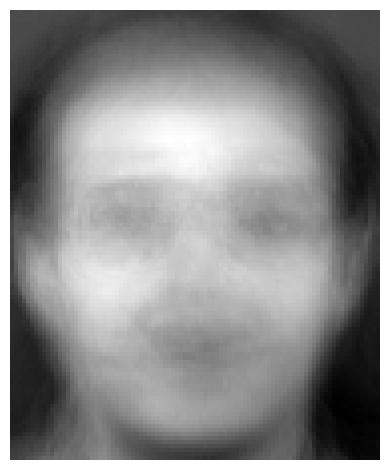

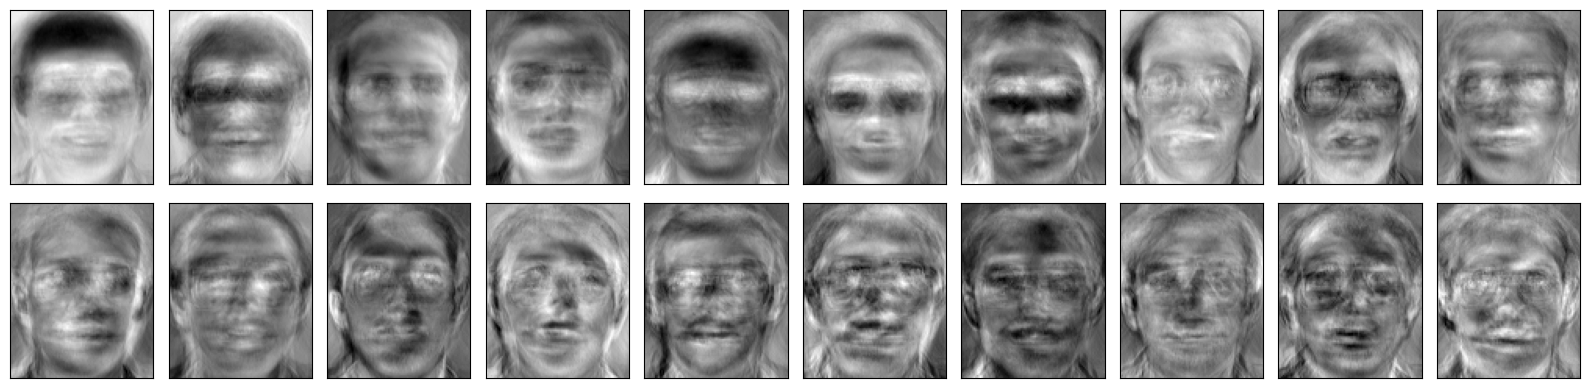

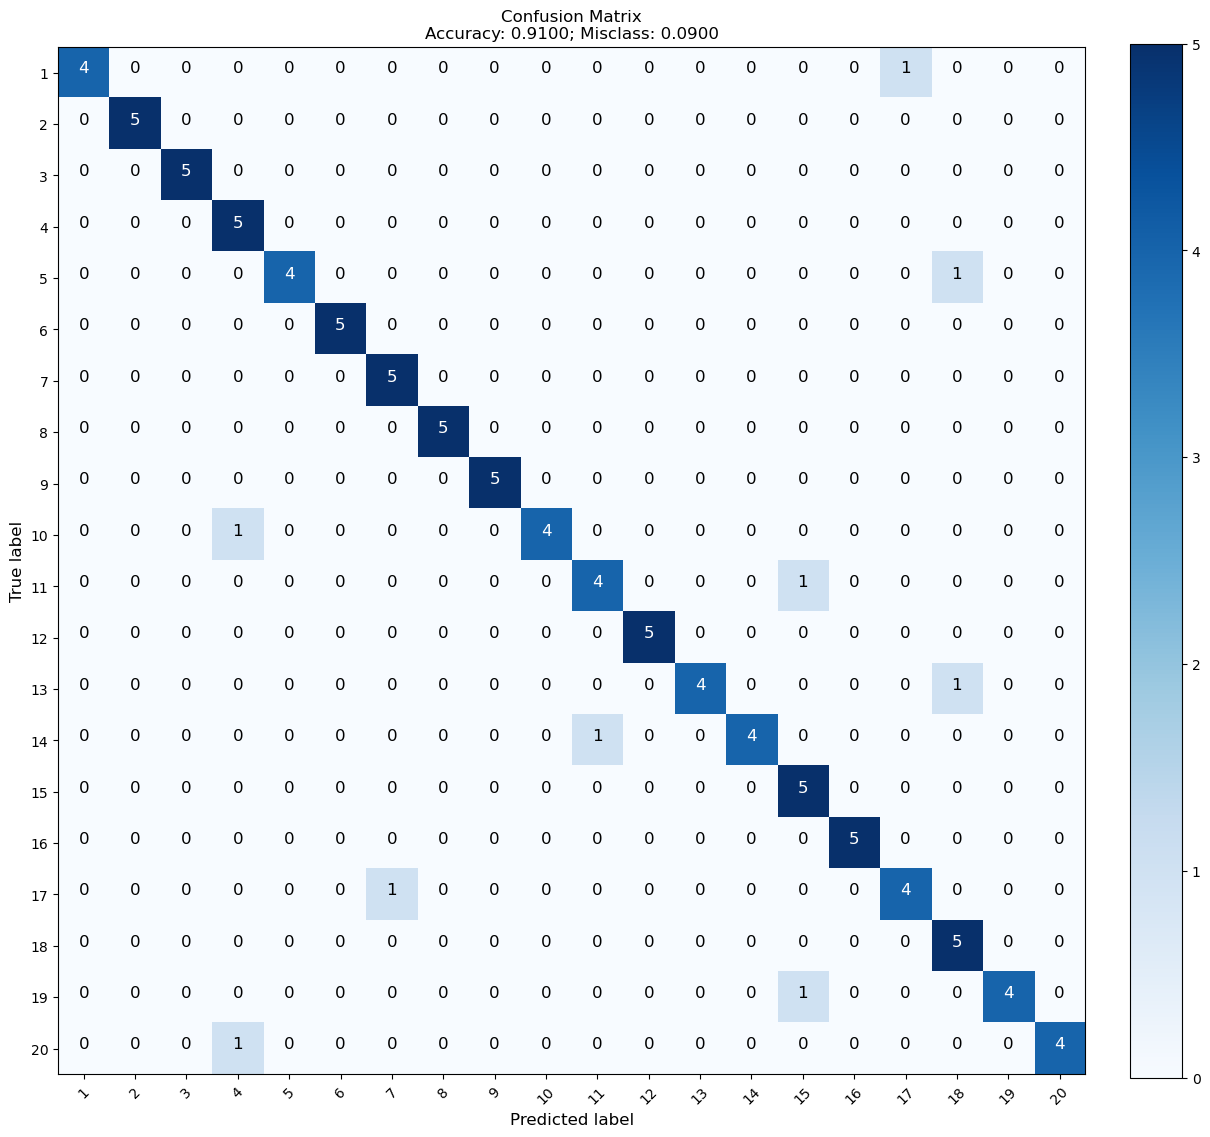

In [12]:
# n_components: number of principal components
n_components_pca = 50
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off')

fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## 200 Components

For EACH of all the 40 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]
Training faces: 200
Size of each sample: 10304
Overall Accuracy: 86%
Subject #1:
	TP: 4, FP: 0, TN: 195, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


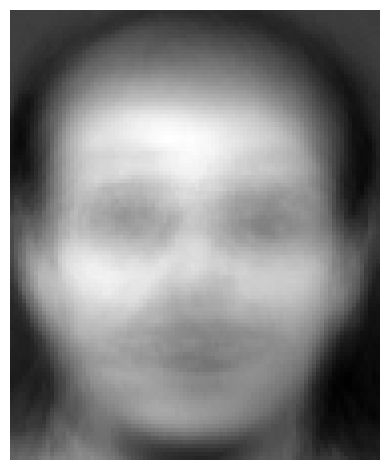

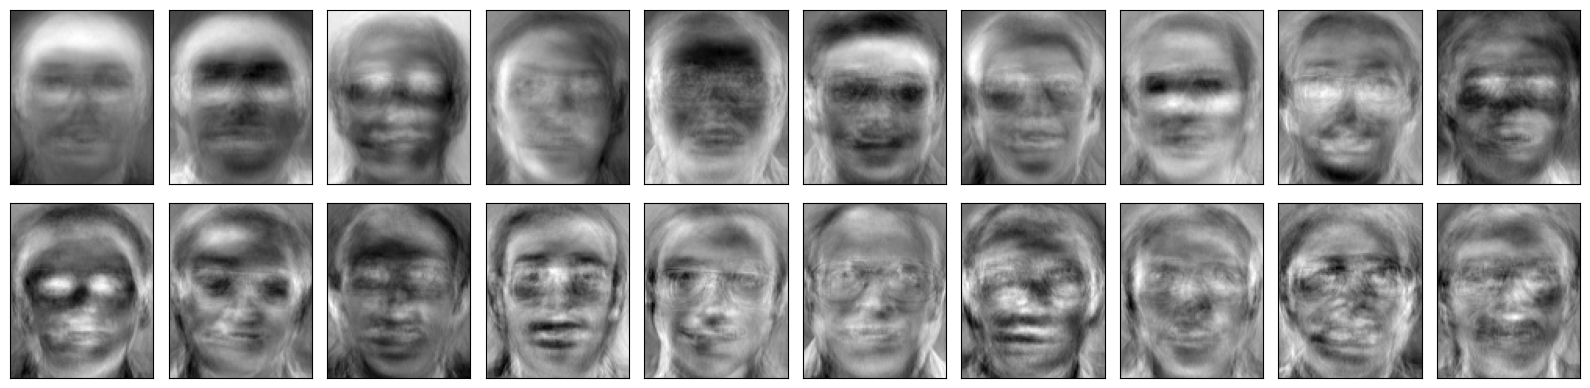

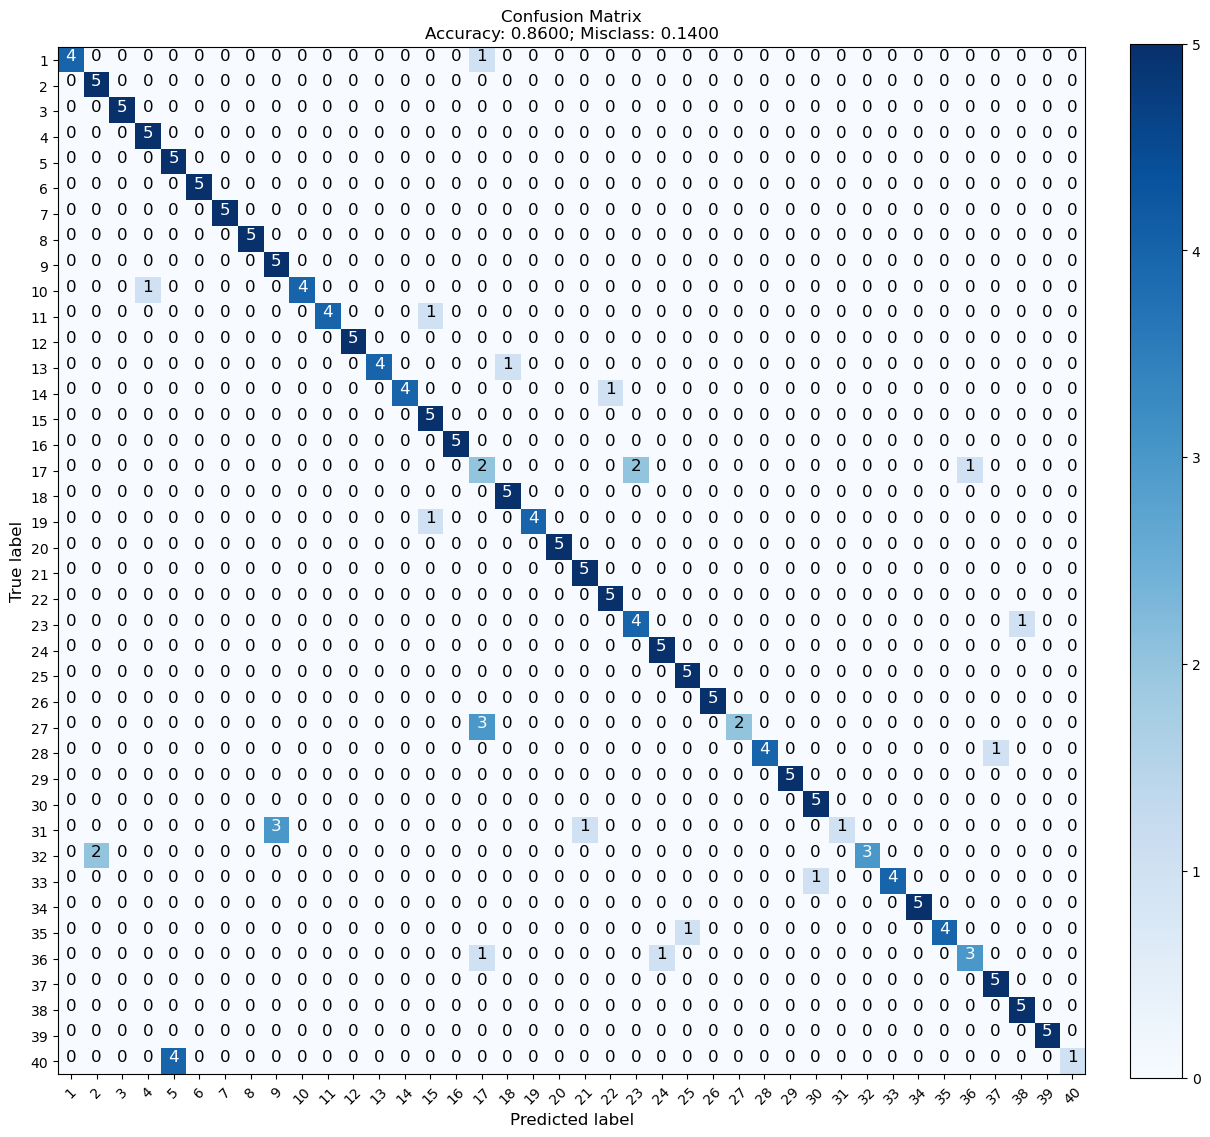

In [14]:
n_subjects = 40

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 3

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])


# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))



# n_components: number of principal components
n_components_pca = 200
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off')

fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Analysis

### Comparison Table

|  PCA # |   Accuracy | Misclass |
|---|---| --- |
|  50| 0.9100| 0.0900|
|  100|  0.9100| 0.0900 |   |   |
|  200|0.8600 |0.1400   |   |   |


After reviewing the confusion matrix, we observed that the accuracy and misclassification rate remained consistent when using 50 and 100 PCA components. However, when utilizing 200 components, we needed to increase the number of subjects to 40 to ensure an adequate sample size. Despite this adjustment, the accuracy for 200 PCA components decreased compared to using 50 and 100 components, with a recorded accuracy of 0.8600 and a misclassification rate of 0.1400.

**Exercise 4** (2 marks): Evaluate the impact of the number of neighbors (K) defined for the KNN. Using the same data separation (20 subjects, 8 images per subject are used for training and 2 for testing). Conduct the two experiments considering, for example: 1) 5 neighbors and 2) 11 neighbors. Compare the KNN classifier results, using the Confusion matrices, and draw the conclusions.

## Experiment #1 - 5 KNN Neighbors

For EACH of all the 20 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]
Training faces: 100
Size of each sample: 10304
Overall Accuracy: 84%
Subject #1:
	TP: 4, FP: 0, TN: 95, FN: 1
	TPR: 80.00%, TNR: 100.00%, FPR: 0.00%, FNR: 20.00%


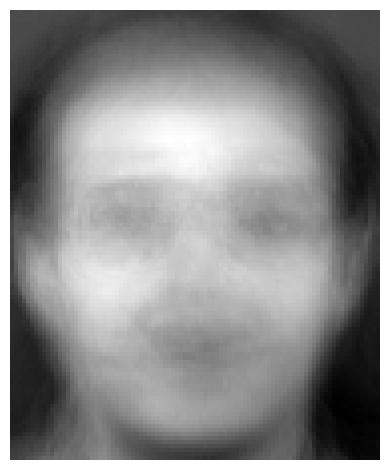

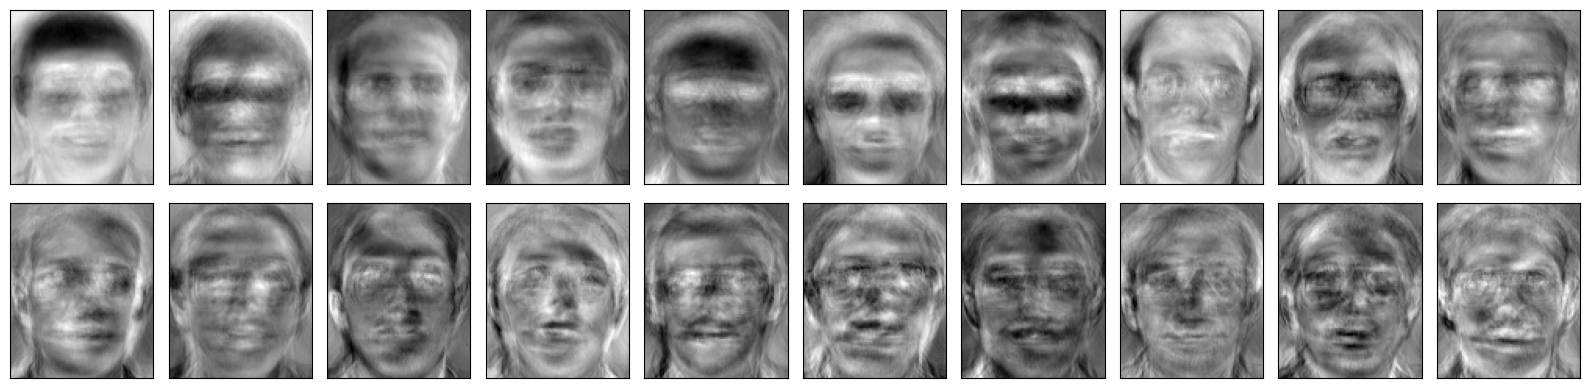

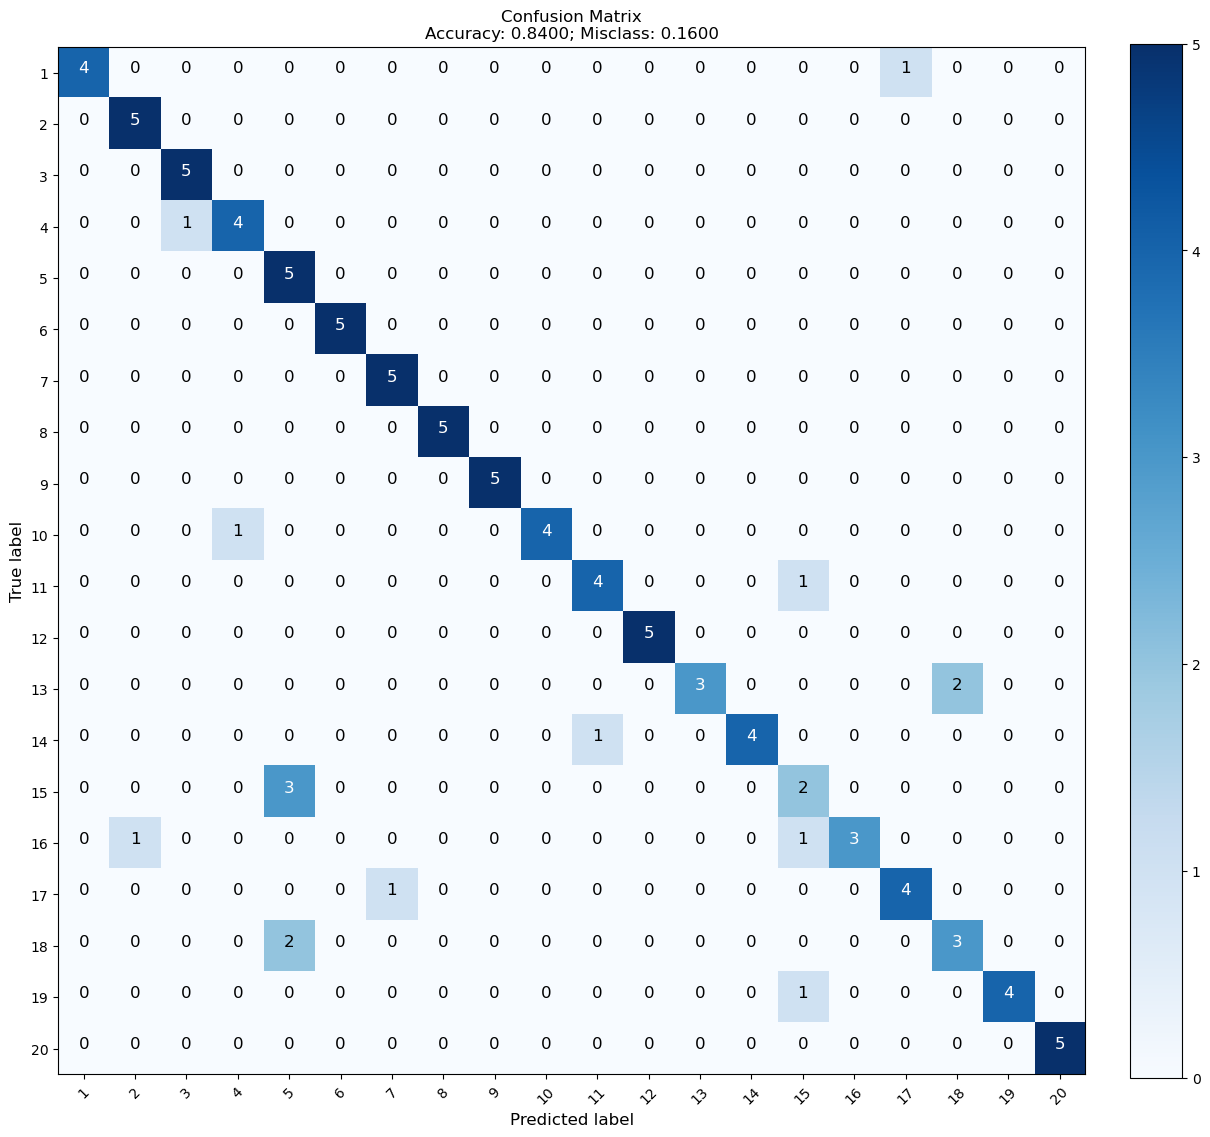

In [17]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 5

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])


# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))



# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off')

fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Experiment #2 - 11 KNN Neighbors

For EACH of all the 20 subjects:
	5 images will be used for TRAINING: [1, 2, 3, 4, 5]
	5 images will be used for TEST: [6, 7, 8, 9, 10]
Training faces: 100
Size of each sample: 10304
Overall Accuracy: 73%
Subject #1:
	TP: 3, FP: 0, TN: 95, FN: 2
	TPR: 60.00%, TNR: 100.00%, FPR: 0.00%, FNR: 40.00%


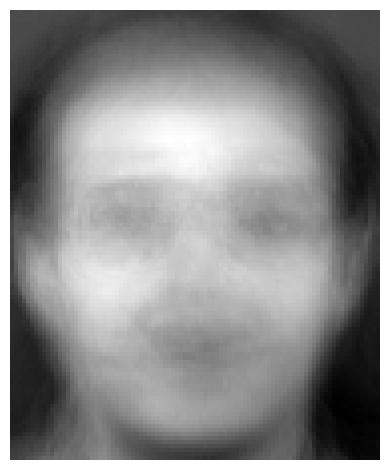

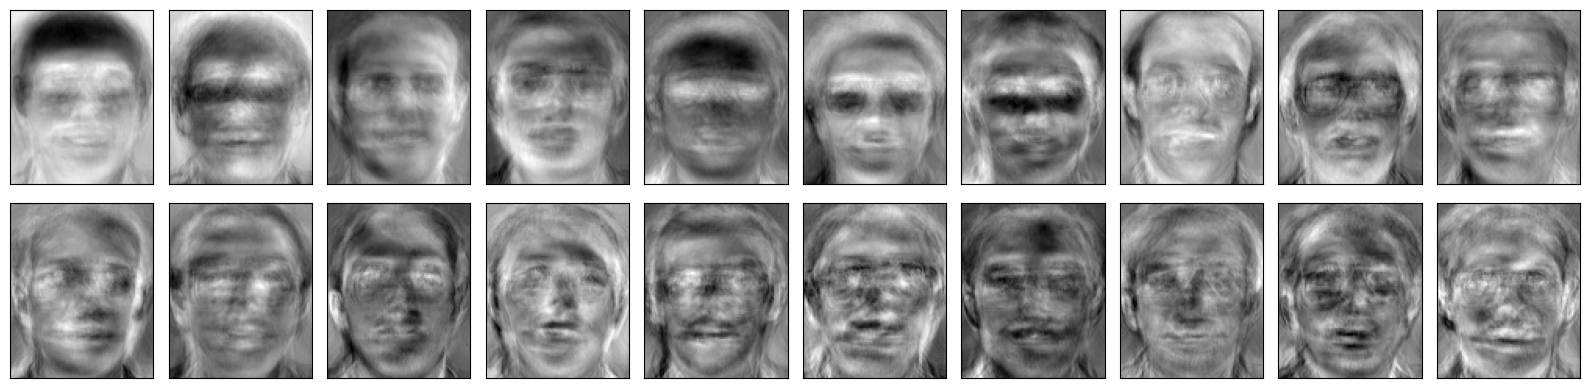

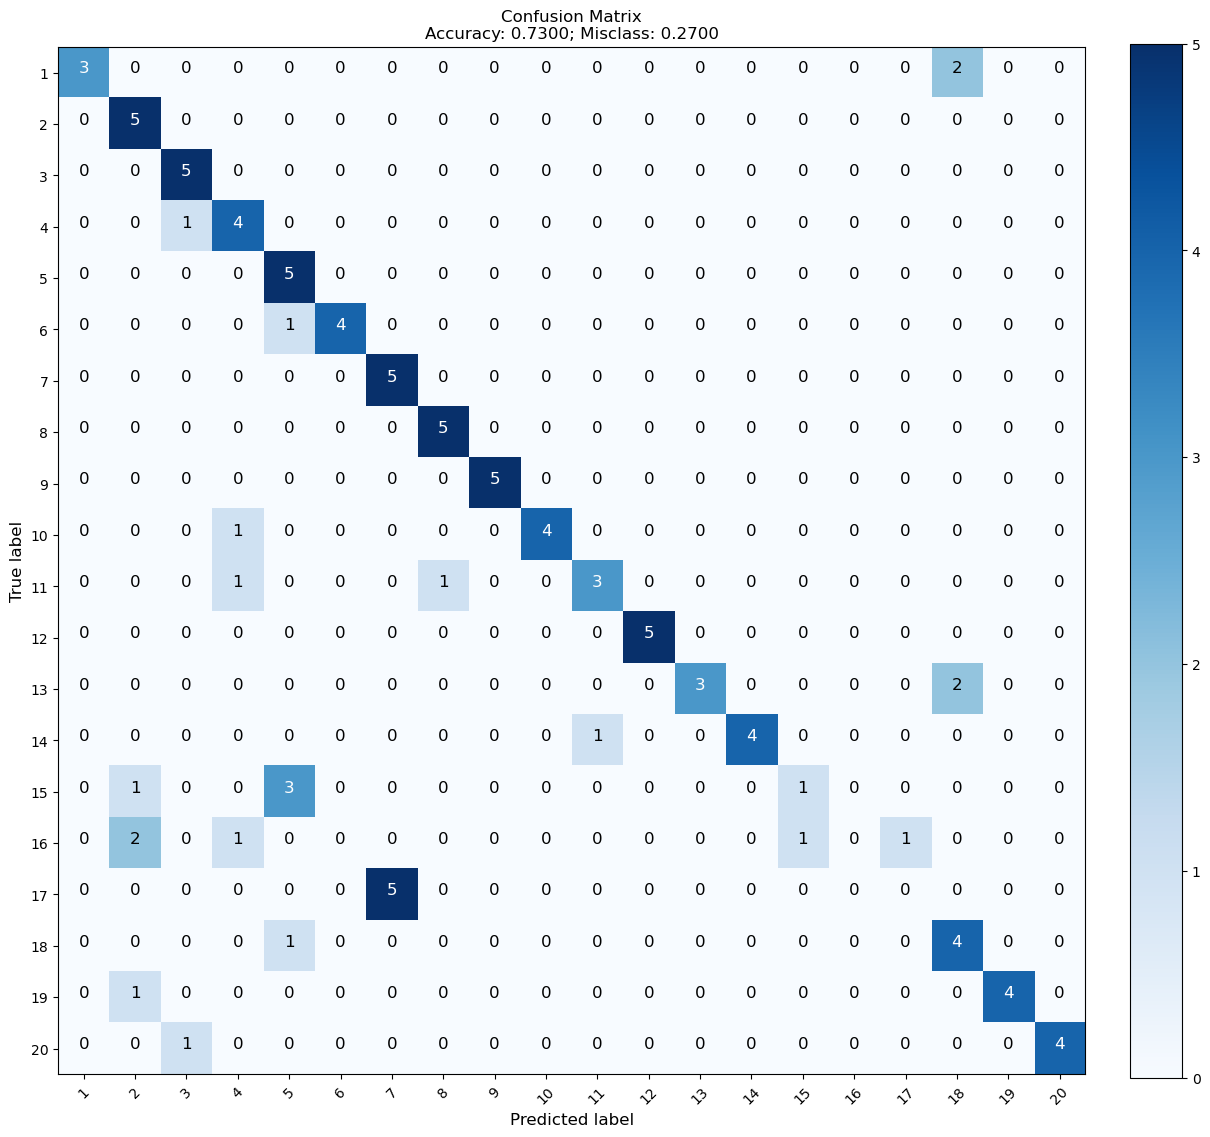

In [19]:
n_subjects = 20

# number of images should sum to 10
n_training_images = 5
n_test_images = 5

knn_neighbors = 11

# You can specify you directory here, please, change the string below:
path = '../ATT dataset/'

print('For EACH of all the %d subjects:' % (n_subjects))
print('\t%d images will be used for TRAINING:' % (n_training_images), [x for x in range(1,n_training_images+1)])
print('\t%d images will be used for TEST:' % (n_test_images), [x for x in range(n_training_images+1, n_training_images+n_test_images+1)])


# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

print('Training faces:', len(trainingFaces))
print('Size of each sample:', len(trainingFaces[0]))



# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

plt.imshow(pca.mean_.reshape(img.shape))
plt.axis('off')

fig = plt.figure(figsize=(16, 6))
for i in range(20):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(img.shape))

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
prediction_evaluation(predictedLabels, testingLabels)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

plot_confusion_matrix(cm=confusionMatrix,
                      target_names = [i for i in range(1, n_subjects+1)])

## Analysis


Based on the summarized results, it is evident that the number of neighbors (K) in the KNN algorithm significantly impacts the model's performance. The model utilizing 5 neighbors exhibited superior accuracy and lower misclassification rates compared to the model using 11 neighbors. Specifically, the 5 neighbor model achieved an impressive 84% accuracy, indicating its ability to effectively classify the dataset. However, increasing the number of neighbors to 11 resulted in a noticeable drop in accuracy to 73%. This decline in performance suggests that an excessive number of neighbors can lead to underfitting, where the model is too simplistic to capture the dataset's complexity adequately. Therefore, it is crucial to select an appropriate value for K in KNN to achieve optimal performance. In this scenario, the 5 neighbor model outperformed the 11 neighbor model, highlighting the importance of balancing model complexity with dataset characteristics.

## Conclusion


In conclusion, our lab experiment delved into the intricacies of face recognition using PCA and KNN. We built a gallery with selected subjects' images, calculating Euclidean distances for classification. Determining the first and second thresholds helped classify known and unknown faces, along with non-face images. Our evaluation of PCA components (50, 100, and 200) revealed that 50 and 100 components outperformed 200, likely due to overfitting with the higher component count and limited dataset size. Similarly, in the KNN analysis, using 5 neighbors surpassed using 11, indicating that too many neighbors can lead to an underfitted model, especially with a sample size nearing the number of neighbors. These findings emphasize the need to balance model complexity and dataset size for optimal face recognition performance.